## Getting Started
In this notebook will will show direct access of archive products in the AWS Simple Storage Service (S3). In this demo, we will showcase the usage of **SWOT Simulated Level-2 KaRIn SSH from GLORYS for Science Version 1**. More information on the datasets can be found at https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1.

We will access the data from inside the AWS cloud (us-west-2 region, specifically) and load a time series made of multiple netCDF datasets into a single xarray dataset. This approach leverages S3 native protocols for efficient access to the data.

In the future, if you want to use this notebook as a reference, please note that we are not doing collection discovery here- we assume the collection of interest has been determined. 

### Requirements

This can run in the small openscapes instance, that is, it only needs 8GB of memory  and ~2 CPU.

If you want to run this in your own AWS account, you can use a *t2.large* instance, which also has 2 CPU and 8GB memory. It's improtant to note that all instances using direct S3 access are required to run in us-west-2, or the Oregon region.

This instance will cost approximately $0.0832 per hour. The entire demo can run in considerably less time.

### Imports 

Most of these imports are from the Python standard library. However, you will need to install these packages into your Python 3 environment if you have not already done so:

```
boto3
s3fs
xarray
matplotlib
cartopy
```

## Learning Objectives
* import needed libraries
* authenticate for NASA Earthdata archive (Earthdata Login)
* obtain AWS credentials for Earthdata DAAC archive in AWS S3
* access DAAC data by downloading directly from S3 within US-west 2 and operating on those files.
* access DAAC data directly from the in-region S3 bucket without moving or downloading any files to your local (cloud) workspace
* plot the first time step in the data

In [1]:
import boto3
import json
import xarray as xr
import s3fs
import os
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from os import path
%matplotlib inline


## Get a temporary AWS Access Key based on your Earthdata Login user ID

By accessing https://archive.podaac.earthdata.nasa.gov/s3credentials, you will be given an AWS Access credential. This key will last 1 hour and will give you access to PO.DAAC S3 Collection buckets. We will store this key in our environment variables for use by the btot3 s3fs libraries.

In [2]:
# Paste the result of your accessing and login to the s3Credential endpoint above into the 's3_credential' variable here:
# https://archive.podaac.earthdata.nasa.gov/s3credentials
s3_credential ='''
'''
creds = json.loads(s3_credential)

In [3]:
os.environ["AWS_ACCESS_KEY_ID"] = creds["accessKeyId"]
os.environ["AWS_SECRET_ACCESS_KEY"] = creds["secretAccessKey"]
os.environ["AWS_SESSION_TOKEN"] = creds["sessionToken"]

s3 = s3fs.S3FileSystem(anon=False) 

# Location of data in the PO.DAAC S3 Archive
We need to determine the path for our products of interest. We can do this through several mechanisms. Those are described in the `Finding_collection_concept_ids.ipynb` notebook.

After using that guide to find our S3 location, we end up with:

```json
{
    ...
    "DirectDistributionInformation": {
        "Region": "us-west-2",
        "S3BucketAndObjectPrefixNames": [
            "podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/",
            "podaac-ops-cumulus-public/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/"
        ],
        "S3CredentialsAPIEndpoint": "https://archive.podaac.earthdata.nasa.gov/s3credentials",
        "S3CredentialsAPIDocumentationURL": "https://archive.podaac.earthdata.nasa.gov/s3credentialsREADME"
    },
    ...
}
```



# Now that we have the bucket location...

It's time to find our data! Below we are using a 'glob' to find file names matching a pattern. Here, we want any files matching the pattern used below, this equates, in science, terms, to Cycle 001 and the first 10 passes. This information can be gleaned form product description documents. Another way of finding specific data files would be to search on cycle/pass from CMR and use the S3 links provided in the resulting metadata directly instead of doing a glob (essentially an 'ls').

```
what are the average granule sizes
```

In [4]:
s3path = 's3://podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_00*.nc'
remote_files = s3.glob(s3path)

In [5]:
remote_files

['podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_001_20140412T120000_20140412T125126_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_002_20140412T125126_20140412T134253_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_003_20140412T134253_20140412T143420_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_004_20140412T143420_20140412T152546_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_005_20140412T152547_20140412T161713_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_006_20140412T161714_20140412T170840_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_

# Traditional Access - get these files from S3 and store them on your running instance

Here we will leverage the speed of transfering data within the cloud to our running instance (this notebook!). We will download 10 files into the 'DEMO_FILES' directory to show you cloud and traditional access.

In [7]:
%%time
for f in remote_files:
    s3.download(f, "DEMO_FILES/" + os.path.basename(f))

CPU times: user 286 ms, sys: 204 ms, total: 489 ms
Wall time: 3.08 s


In [8]:
#%%prun
ds = xr.open_mfdataset("DEMO_FILES/SWOT_L2_LR_SSH_Expert_001_0*.nc", combine='nested', concat_dim="num_lines")

In [9]:
ds


<xarray.Dataset>
Dimensions:                                (num_lines: 88796, num_pixels: 71, num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/91)
    time                                   (num_lines) datetime64[ns] dask.array<chunksize=(9866,), meta=np.ndarray>
    time_tai                               (num_lines) datetime64[ns] dask.array<chunksize=(9866,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float32 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssh_karin_2                            (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ...                                     ...
    simulated_error_baseline_dilation      (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_timing                 (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_roll                   (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_phase                  (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_orbital                (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_karin                  (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
Attributes: (12/32)
    Conventions:                CF-1.7
    title:                      Level 2 Low Rate Sea Surface Height Data Prod...
    institution:                CNES/JPL
    source:                     Simulate product
    history:                    2021-09-10 09:54:55Z : Creation
    platform:                   SWOT
    ...                         ...
    right_last_longitude:       131.81928697472432
    right_last_latitude:        77.03254381435897
    wavelength:                 0.008385803020979
    orbit_solution:             POE
    ellipsoid_semi_major_axis:  6378137.0
    ellipsoid_flattening:       0.003352810664781205

Now let's plot these 10 files in a chosen projection.

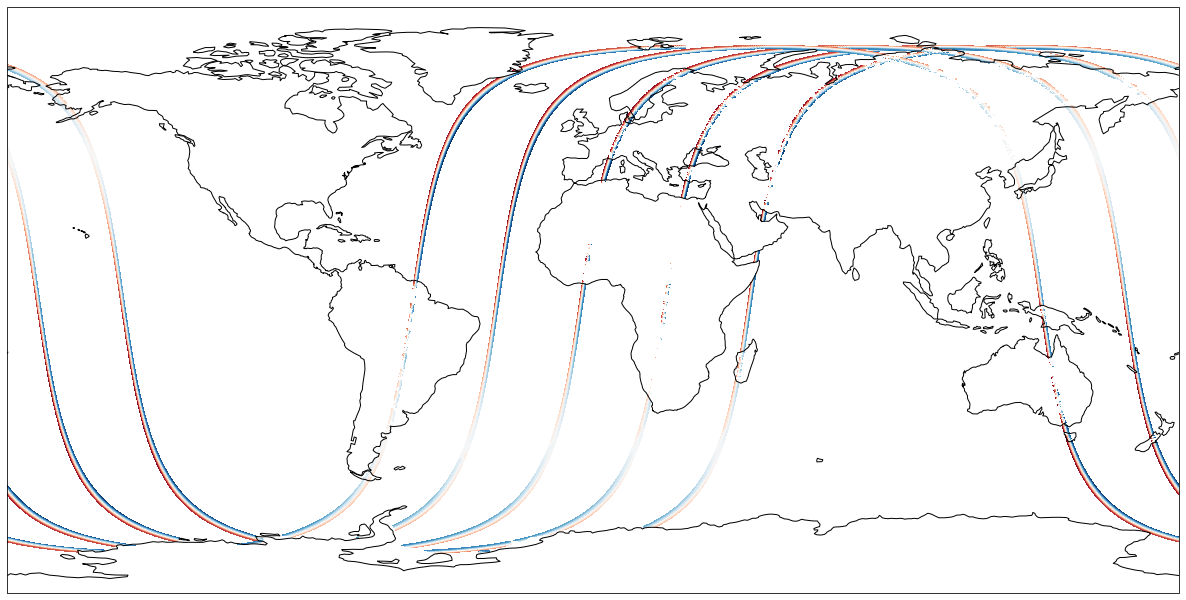

In [11]:
plt.figure(figsize=(21, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([150, 180, 45, 90])
ax.set_global()
ds.ssh_karin.plot.pcolormesh(
 ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=False
)
ax.coastlines()

#ds.ssh_karin.plot()


# Access Files without any Downloads to your disk

We can also do that same plot without 'downloading' the data to our disk first. Let's try access the data from S3 directly through xarray.

In [12]:
s3path = 's3://podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_00*.nc'
remote_files = s3.glob(s3path)

In [13]:
fileset = [s3.open(file) for file in remote_files]

In [14]:

%%time
data = xr.open_mfdataset(fileset,engine='h5netcdf', combine='nested', concat_dim="num_lines", decode_times=False)
    


CPU times: user 4.55 s, sys: 384 ms, total: 4.93 s
Wall time: 8.67 s


In [15]:
data.ssha_karin

<xarray.DataArray 'ssha_karin' (num_lines: 88796, num_pixels: 71)>
dask.array<concatenate, shape=(88796, 71), dtype=float64, chunksize=(9869, 71), chunktype=numpy.ndarray>
Coordinates:
    latitude         (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    longitude        (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    latitude_nadir   (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir  (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Attributes:
    long_name:  sea surface height anomaly
    units:      m
    valid_min:  [-1000000]
    valid_max:  [1000000]
    comment:    ['Sea surface height anomaly from the KaRIn measurement = ssh...

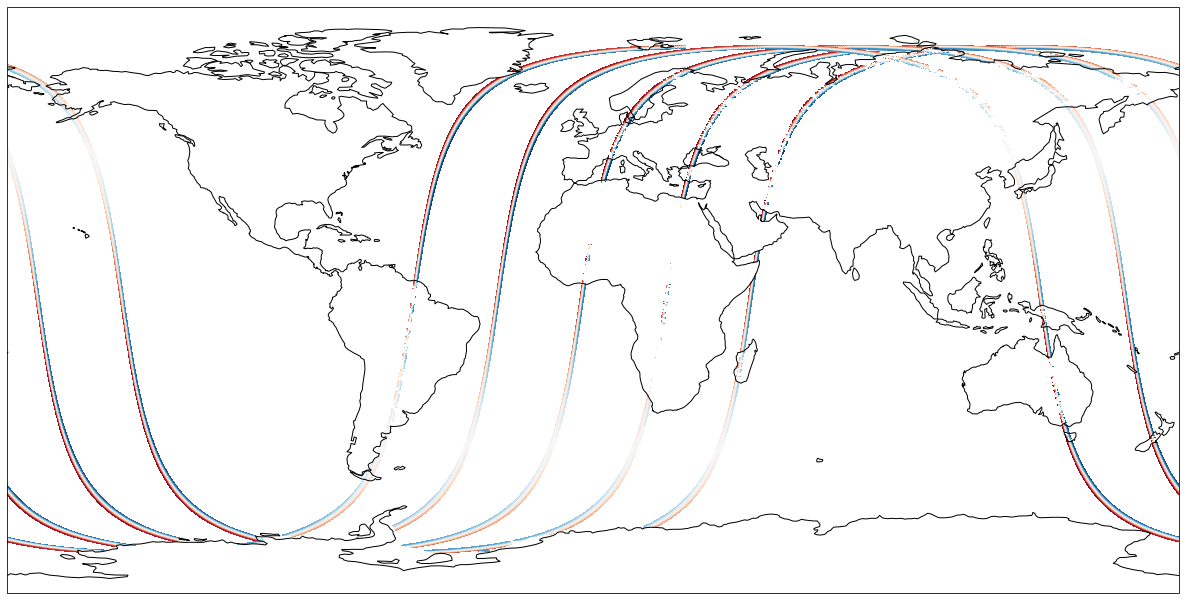

In [16]:
plt.figure(figsize=(21, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
data.ssha_karin.plot.pcolormesh(
 ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=False
)
ax.coastlines()

## A final word...

Accessing data completely from S3 and in memory are affected by various things.

1. The format of the data- archive formats like NetCDF, GEOTIFF, HDF  vs cloud optimized data structures (Zarr, kerchunk, cog). cloud formats are made for accessing only the pieces of data of interest needed at the time of request (e.g. a subset, timestep, etc)
2. The internal structure of the data. Tools like xarray make a lot of assumptions about how to open and read a file. Sometimes the internals don't fit the xarray 'mold' and we need to continue to work with data providers and software providers to make these two sides work together.